# Wavenet for Forecasting

In this tutorial, we show how to quickly set up and train an CNN regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
from deep4cast.topologies import WaveNet

import deep4cast.custom_metrics as metrics
from pandas import read_table

%matplotlib inline

Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df[['load', 'temp']].astype('float32').values
data = np.expand_dims(data, axis=0)

# We just need a small holdout dataset for evaluation purposes
holdout = 24 # hours
train_data = data[:,:-holdout,[0]]
test_data = data[:,-holdout:,[0]]

# Let's peek at the data
df.head()

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000
3,2012-01-01 03:00:00,2402.0,31.000000
4,2012-01-01 04:00:00,2403.0,32.000000


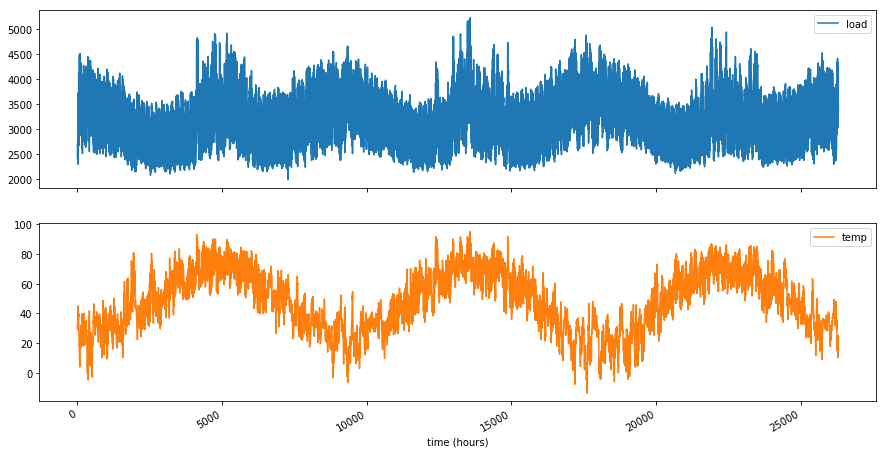

In [3]:
# Let plot the data
df.plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

## Topology for CNN

Here, we are simply stacking a few convolutional layers on top of each other to build a deep architecture. 

In [4]:
topology = WaveNet(num_filters=16, num_layers=1)

Let's fit the forecaster!

In [5]:
train_data.shape

(1, 26280, 1)

In [6]:
forecaster = Forecaster(
    topology,
    lag=48,  # This is the number of time steps used to predict the future for each data point
    horizon=24,  # This is how many time steps into the future we want to produce
    optimizer='nadam',  # Which optimizer the forecaster is using
    loss='heteroscedastic_gaussian', 
    lr=0.001,  # This is the learning rate for the optimizer
    max_epochs=50,  # Maximum number of epochs that the optimizer will perform
    batch_size=32
)

The target variable here denotes the index of the target time series, we are trying to forecast.

In [7]:
forecaster.fit(train_data, targets=[0], patience=5, verbose=1)  # patience is the number of epochs to wait until early stopping is executed

(48, 1)


AttributeError: 'WaveNet' object has no attribute '_inbound_nodes'

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'blue') 
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(['loss', 'validation loss'])

As before, we can use the forecaster to make predictions

In [ ]:
predictions = forecaster.predict(data=train_data, n_samples=100)

In [ ]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[:,:,:1]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[:,:,:1]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[:,:,:1]), 2)))

In [ ]:
# We're printing the test set data and the predictions for the load data
plt.plot(predictions['samples'][:,0,:,0].T, 'g', alpha=0.01)
plt.plot(test_data[0,:,0].T, 'k')
plt.plot(predictions['mean'][0,:,0], 'r')
plt.plot(predictions['lower_quantile'][0,:,0], 'r--')
plt.plot(predictions['upper_quantile'][0,:,0], 'r--')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()